In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- paths / config ---
results_dir = Path("results")

SYSTEM_SIZE = 16
TRAIN_SAMPLES = 20_000

csv_path = results_dir / f"eval_results_L{SYSTEM_SIZE}_N{TRAIN_SAMPLES}.csv"
ref_path = Path(f"tfim_{SYSTEM_SIZE}_entangle_ref.csv")  # optional ED reference

ATOL_H = 1e-3
cmap = plt.get_cmap("tab10")

In [2]:
df = pd.read_csv(csv_path)

# expected columns: seed, h, l, s2, s2_err, type
needed = {"seed", "h", "l", "s2", "s2_err", "type"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in {csv_path.name}: {sorted(missing)}")

# support h values (from your evaluation output)
h_support_vals = sorted(df.loc[df["type"] == "support", "h"].unique())
seeds = sorted(df["seed"].unique())
l_axis = sorted(df["l"].unique())

print(f"Loaded: {csv_path.name}")
print(f"Rows: {len(df)}")
print(f"Seeds: {len(seeds)} -> {seeds[:10]}{' ...' if len(seeds) > 10 else ''}")
print(f"Support h: {len(h_support_vals)} -> {h_support_vals}")
print(f"l-range: {min(l_axis)}..{max(l_axis)}")

ref_df = pd.read_csv(ref_path) if ref_path.exists() else None
print(f"ED ref: {'loaded' if ref_df is not None else 'not found'} ({ref_path.name})")

Loaded: eval_results_L16_N20000.csv
Rows: 1680
Seeds: 10 -> [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
Support h: 7 -> [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]
l-range: 1..8
ED ref: loaded (tfim_16_entangle_ref.csv)


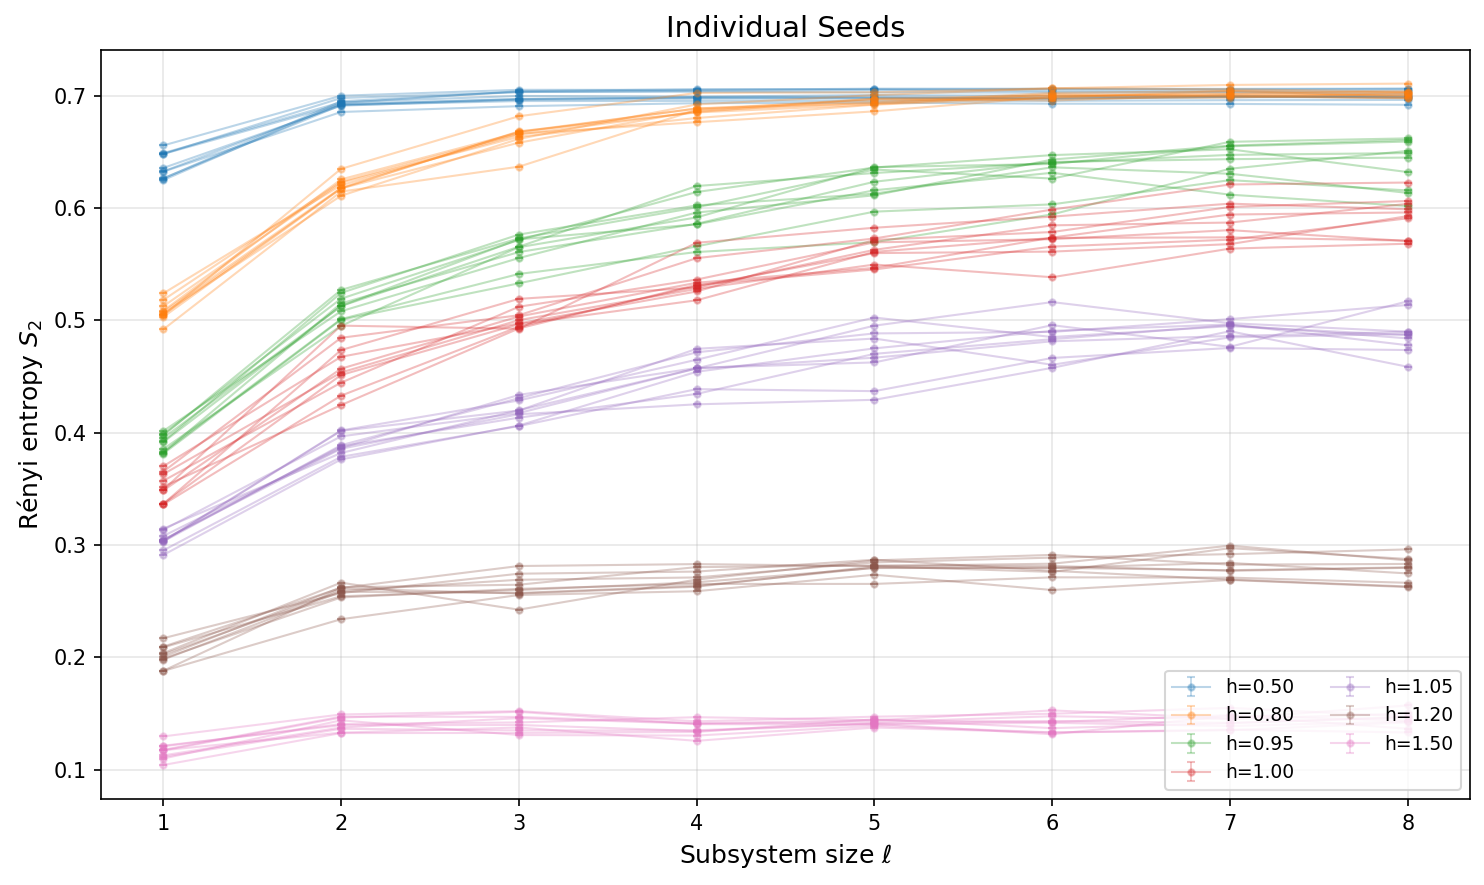

In [4]:
# Cell 1 - plot (individual seeds)
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(111)

# support h values + seeds
h_support_vals = sorted(df.loc[df["type"] == "support", "h"].unique())
seeds = sorted(df["seed"].unique())

for i, h in enumerate(h_support_vals):
    color = cmap(i % 10)
    subset_h = df[np.isclose(df["h"], h, atol=ATOL_H)]

    for seed in seeds:
        sub = subset_h[subset_h["seed"] == seed].sort_values("l")
        if sub.empty:
            continue

        lbl = f"h={h:.2f}" if seed == seeds[0] else "_nolegend_"
        ax.errorbar(
            sub["l"], sub["s2"], yerr=sub["s2_err"],
            fmt="o-", color=color, markersize=3, linewidth=1.0,
            elinewidth=0.8, capsize=2, alpha=0.30, label=lbl
        )

ax.set_title("Individual Seeds", fontsize=14)
ax.set_xlabel(r"Subsystem size $\ell$", fontsize=12)
ax.set_ylabel(r"Rényi entropy $S_2$", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [6]:
# Cell 2 - averages across seeds
df_sup = df[df["type"] == "support"].copy()

# mean + SEM across seeds for each (h, l)
avg_df = (
    df_sup.groupby(["h", "l"])["s2"]
    .agg(["mean", "std", "count"])
    .reset_index()
    .rename(columns={"mean": "s2_mean", "std": "s2_std", "count": "n"})
)
avg_df["s2_sem"] = avg_df["s2_std"] / np.sqrt(avg_df["n"].clip(lower=1))

# keep only relevant cols
avg_df = avg_df[["h", "l", "s2_mean", "s2_sem", "n"]].sort_values(["h", "l"]).reset_index(drop=True)

print(f"avg_df rows: {len(avg_df)}")
avg_df


avg_df rows: 56


,h,l,s2_mean,s2_sem,n
0,0.50,1,0.638046,0.003572,10
1,0.50,2,0.693495,0.001248,10
2,0.50,3,0.699363,0.001489,10
3,0.50,4,0.700267,0.001374,10
4,0.50,5,0.700610,0.001400,10
5,0.50,6,0.700137,0.001434,10
6,0.50,7,0.700525,0.001339,10
7,0.50,8,0.700407,0.001440,10
8,0.80,1,0.508251,0.002766,10
9,0.80,2,0.620657,0.002097,10


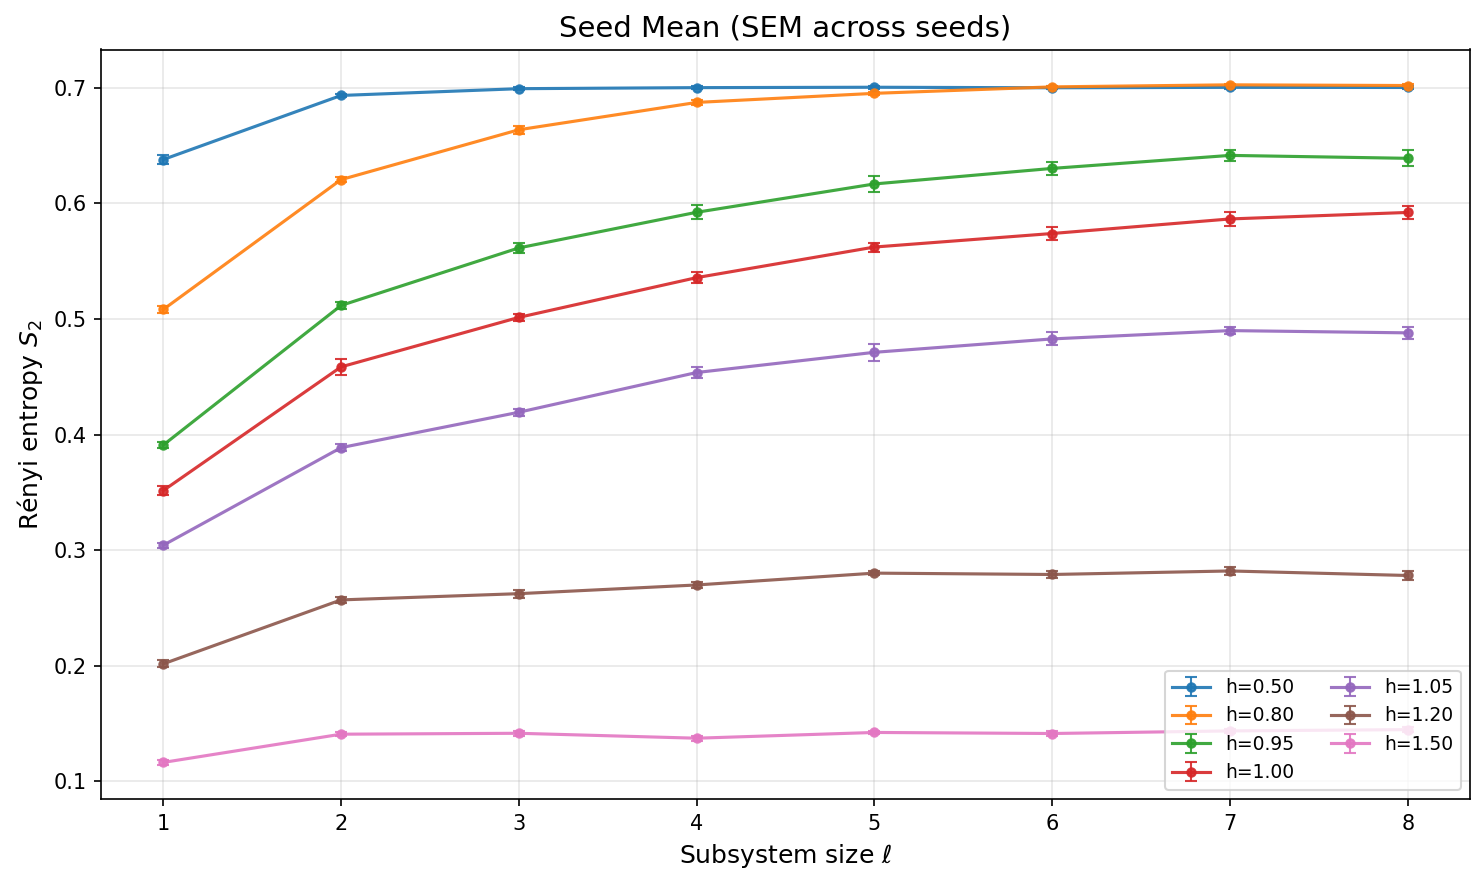

In [7]:
# Cell 3 - plot (averages)
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = fig.add_subplot(111)

for i, h in enumerate(h_support_vals):
    color = cmap(i % 10)
    sub = avg_df[np.isclose(avg_df["h"], h, atol=ATOL_H)].sort_values("l")
    if sub.empty:
        continue

    ax.errorbar(
        sub["l"], sub["s2_mean"], yerr=sub["s2_sem"],
        fmt="o-", color=color, markersize=4, linewidth=1.5,
        elinewidth=1.0, capsize=3, alpha=0.9, label=f"h={h:.2f}"
    )

ax.set_title("Seed Mean (SEM across seeds)", fontsize=14)
ax.set_xlabel(r"Subsystem size $\ell$", fontsize=12)
ax.set_ylabel(r"Rényi entropy $S_2$", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
